# Creating a LlamaIndex RAG Pipeline with NL2SQL and Metadata Filtering!

We'll be putting together a system for querying both qualitative and quantitative data using LlamaIndex.

The acitvities will be broken down as follows:

- 🤝 Breakout Room #1
  - Task 1: Load Dependencies
  - Task 2: Set Env Variables and Set Up WandB Callback
  - Task 3: Initialize Settings
  - Task 4: Index Creation
  - Task 5: Simple RAG - `QueryEngine`
  - Task 6: Auto Rertriever Functional Tool
- 🤝 Breakout Room #2
  - Task 1: Quantitative RAG Pipeline with NL2SQL Tooling
  - Task 2: Combined RAG Pipeline

Before we get started, however, a quick note on terminology.

# 🤝 Breakout Room #1

## BOILERPLATE

This is only relevant when running the code in a Jupyter Notebook.

In [284]:
import nest_asyncio

nest_asyncio.apply()

import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

## Load Dependencies

Let's grab our core `llama-index` library, as well as OpenAI's Python SDK.

We'll be leveraging OpenAI's suite of APIs to power our RAG pipelines today.

> NOTE: You can safely ignore any pip errors that occur during the running of these cells.

In [286]:
! pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.3 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1
    Uninstalling pip-24.1:
      Successfully uninstalled pip-24.1


In [287]:
! pip install -qU llama-index openai anthropic

We'll be collecting our semantic data from Wikipedia - and so will need the [Wikipedia Reader](https://github.com/run-llama/llama_index/tree/main/llama-index-integrations/readers/llama-index-readers-wikipedia)!

In [288]:
! pip install -qU wikipedia llama-index-readers-wikipedia

Our vector database today will be powered by [QDrant](https://qdrant.tech/) and so we'll need that package as well!

In [289]:
! pip install -qU llama-index-vector-stores-qdrant qdrant-client

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.19.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 5.27.2 which is incompatible.
opentelemetry-proto 1.25.0 requires protobuf<5.0,>=3.19, but you have protobuf 5.27.2 which is incompatible.
proto-plus 1.23.0 requires protobuf<5.0.0dev,>=3.19.0, but you have protobuf 5.27.2 which is incompatible.
wandb 0.16.6 requires protobuf!=4.21.0,<5,>=3.19.0; python_version > "3.9" and sys_platform == "linux", but you have protobuf 5.27.2 which is incompatible.


Finally, we'll need to grab a few dependencies related to our quantitative data!

In [290]:
! pip install -q -U sqlalchemy pandas

We'll can use [Weights and Biases](https://docs.wandb.ai/guides/prompts) (WandB) as a visibility platform, as well as storing our index!

In [291]:
! pip install -qU wandb llama-index-callbacks-wandb

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-tools 1.64.1 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.3 which is incompatible.


In [292]:
import os
import getpass

os.environ["WANDB_API_KEY"] = getpass.getpass("WandB API Key: ")

In [293]:
import wandb

We'll also need to set a callback handler for WandB to ensure smooth operation of our traces!

In [294]:
import llama_index
from llama_index.core import set_global_handler
# from llama_index.callbacks.global_handlers import set_global_handler
# wandb.init(settings=wandb.Settings(start_method="thread"))

set_global_handler(eval_mode="wandb", run_args={"project": "Llama-index-rag"})
wandb_callback = llama_index.core.global_handler

## Task 2: Set Env Variables and Set Up WandB Callback

Let's set our API keys for both OpenAI and WandB!

In [295]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

### OPTIONAL ADVANCED PATH:

Instead of OpenAI - you could use Anthropic's new Claude model `Sonnet 3.5`!

Let's see how the flow might be different if you wanted to use the latest and greatest from Anthropic!

> NOTE: You will need an [API Key](https://www.anthropic.com/news/claude-3-5-sonnet) for `Sonnet 3.5` for the following cells to work!

In [296]:
# OPTIONAL ADVANCED PATH
! pip install -qU llama-index-llms-anthropic

In [17]:
# OPTIONAL ADVANCED PATH
os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Anthropic API Key: ")

Anthropic API Key: ··········


In [18]:
# OPTIONAL ADVANCED PATH
from llama_index.llms.anthropic import Anthropic
from llama_index.core import Settings

Settings.llm = Anthropic(model="claude-3-5-sonnet-20240620")

## Task 3: Settings

LlamaIndex lets us set global settings which we can use to influence the default behaviour of our components.

Let's set our LLM and our Embedding Model!

In [297]:
from llama_index.llms.openai import OpenAI
from llama_index.core import Settings

Settings.llm = OpenAI(model="gpt-4o")

In [298]:
from llama_index.embeddings.openai import OpenAIEmbedding
Settings.embedding = OpenAIEmbedding(model="text-embedding-3-small")

## Task 4: `Index` Creation

In order for us to perform RAG in the traditional sense - we need an `Index`.

So what is an `Index`? Well - let's see how LlamaIndex defines it:

> In LlamaIndex terms, an `Index` is a data structure composed of Document objects, designed to enable querying by an LLM. Your Index is designed to be complementary to your querying strategy.

Okay, so we know that we have a boatload of Wikipedia content - and we know that we want to be able to query the `Index` and receive documents that are related to our query - so let's use an `Index` built on the idea of embedding-vectors.

Introducing: `VectorStoreIndex`!

Again, let's see how LlamaIndex defines this:

> A `VectorStoreIndex` is by far the most frequent type of `Index` you'll encounter. The Vector Store Index takes your Documents and splits them up into Nodes. It then creates `vector` embeddings of the text of every node, ready to be queried by an LLM.

Alright, that sounds awesome - let's make one!

### Data Collection

We're just going to be pulling information straight from Wikipedia using the built in `WikipediaReader`.

> NOTE: Setting `auto_suggest=False` ensures we run into fewer auto-correct based errors.

### A note on terminology:

You'll notice that there are quite a few similarities between LangChain and LlamaIndex. LlamaIndex can largely be thought of as an extension to LangChain, in some ways - but they moved some of the language around. Let's spend a few moments disambiguating the language.

- `QueryEngine` -> `LCEL Chain`:
  -  `QueryEngine` is just LlamaIndex's way of indicating something is an LLM "chain" on top of a retrieval system
- `OpenAIAgent` vs. `Agent`:
  - The two agents have the same fundamental pattern: Decide which of a list of tools to use to answer a user's query.
  - `OpenAIAgent` (LlamaIndex's primary agent) does not need to rely on an agent excecutor due to the fact that it is leveraging OpenAI's [functional api](https://openai.com/blog/function-calling-and-other-api-updates) which allows the agent to interface "directly" with the tools instead of operating through an intermediary application process.

There is, however, a much large terminological difference when it comes to discussing data.

##### Nodes vs. Documents

As you're aware of from the previous weeks assignments, there's an idea of `documents` in NLP which refers to text objects that exist within a corpus of documents.

LlamaIndex takes this a step further and reclassifies `documents` as `nodes`. Confusingly, it refers to the `Source Document` as simply `Documents`.

The `Document` -> `node` structure is, almost exactly, equivalent to the `Source Document` -> `Document` structure found in LangChain - but the new terminology comes with some clarity about different structure-indices.

We won't be leveraging those structured indicies today, but we will be leveraging a "benefit" of the `node` structure that exists as a default in LlamaIndex, which is the ability to quickly filter nodes based on their metadata.

![image](https://i.imgur.com/B1QDjs5.png)

In [299]:
from llama_index.readers.wikipedia import WikipediaReader

movie_list = [
    "Dune (2021 film)",
    "Dune: Part Two",
    "The Lord of the Rings: The Fellowship of the Ring",
    "The Lord of the Rings: The Two Towers",
]

wiki_docs = WikipediaReader().load_data(pages=movie_list, auto_suggest=False)

In [300]:
type(wiki_docs), len(wiki_docs), len(movie_list[0])

(list, 4, 16)

### Initializing our `VectorStoreIndex` with QDrant

QDrant is a locally hostable and open-source vector database solution.

It offers powerful features like metadata filtering out of the box, and will suit our needs well today!

We'll start by creating our local `:memory:` client (in-memory and not meant for production use-cases) and our collection.

In [301]:
from llama_index.vector_stores.qdrant import QdrantVectorStore
from qdrant_client import QdrantClient, models

client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="movie_wikis",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

True

Then we'll create our `VectorStore` and `StorageContext` which will allow us to create an empty `VectorStoreIndex` which we will be able to add nodes to later!

In [302]:
from llama_index.core import VectorStoreIndex
from llama_index.core import StorageContext

vector_store = QdrantVectorStore(client=client, collection_name="movie_wikis")

storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex.from_documents(
    [],
    storage_context=storage_context,
)

wandb: Logged trace tree to W&B.


In [303]:
wiki_docs[0]

Document(id_='52659577', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='Dune (titled onscreen as Dune: Part One) is a 2021 American epic science fiction film directed and co-produced by Denis Villeneuve, who co-wrote the screenplay with Jon Spaihts, and Eric Roth. It is the first of a two-part adaptation of the 1965 novel of the same name by Frank Herbert. Set in the distant future, the film follows Paul Atreides as his family, the noble House Atreides, is thrust into a war for the deadly and inhospitable desert planet Arrakis. The ensemble cast includes Timothée Chalamet, Rebecca Ferguson, Oscar Isaac, Josh Brolin, Stellan Skarsgård, Dave Bautista, Stephen McKinley Henderson, Zendaya, Chang Chen, Sharon Duncan-Brewster, Charlotte Rampling, Jason Momoa, and Javier Bardem.\nThe film is the third adaptation of Dune, following David Lynch\'s 1984 film and John Harrison\'s 2000 television miniseries. After an unsuccessfu

### Node Construction

Now we will loop through our documents and metadata and construct nodes.

We'll make sure to explicitly associate our nodes with their respective movie so we can filter by the movie title in the upcoming cells.

You might be thinking to yourself - wait, we never indicated which embedding model this should use - but remember

In [304]:
from llama_index.core import SimpleDirectoryReader
from llama_index.core.ingestion import IngestionPipeline
from llama_index.core.node_parser import TokenTextSplitter
from llama_index.core.extractors import TitleExtractor

# like doument loader and split, wrapped in pipeline
pipeline = IngestionPipeline(transformations=[TokenTextSplitter()])

# each chunk is a document -> node and we associalte metadata to each node. As lon as we are processing chunks of one movie, metadata (here title) stays the same.
for movie, wiki_doc in zip(movie_list, wiki_docs):
  nodes = pipeline.run(documents=[wiki_doc])
  for node in nodes:
      node.metadata = {"title" : movie}
  index.insert_nodes(nodes)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


wandb: Logged trace tree to W&B.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


wandb: Logged trace tree to W&B.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


wandb: Logged trace tree to W&B.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


wandb: Logged trace tree to W&B.


####❓ Question #1:

What `metadata` fields will the nodes in our index have? title

> You will need to write code to find this information

In [305]:
### YOUR CODE HERE
node.metadata

{'title': 'The Lord of the Rings: The Two Towers'}

In [306]:
node

TextNode(id_='3818eb52-68bb-45c0-9e60-d1edf08127ef', embedding=None, metadata={'title': 'The Lord of the Rings: The Two Towers'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='173944', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='8a964a8be15461f84f36562053150f9d13018b43812e308b8610f23e1fe866b9'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='cc76e070-bd63-454d-a84b-d2d45d09f22e', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='96f7df68378bd2c3de3eb971df7e3941799bf270c5d41480bb20eae51bf36dbd')}, text='Best Visual Effects (Jim Rygiel, Joe Letteri, Randall William Cook and Alex Funke) and Best Sound Editing (Ethan Van der Ryn and Michael Hopkins).\nNominee: Best Picture (Fran Walsh, Philippa Boyens, Stephen Sinclair and Peter Jackson, producers), Best Art Direction (Art Direction: Grant Major; Set Decoration: Dan Hennah and Alan Lee), Best Film Editing (Michael J. Horton

In [307]:
list(node.metadata.keys())[0]

'title'

### Persisting and Loading Stored Index with Weights and Biases

Now we can utilize a powerful feature of Weights and Biases - index and artifact versioning!

We can persist our index to WandB to be used and loaded later!

In [308]:
wandb_callback.persist_index(index, index_name="movie-index-qdrant")

wandb: Adding directory to artifact (/home/sahane/AIE3/Week 5/Day 1/wandb/run-20240626_193825-pli86zyn/files/storage)... Done. 0.2s


Now we can load our index from WandB, which is a truly powerful tool!

In [309]:
from llama_index.core import load_index_from_storage

storage_context = wandb_callback.load_storage_context(
    artifact_url="ai_wonders_with_joy/Llama-index-rag/movie-index-qdrant:v0"
)

wandb:   4 of 4 files downloaded.  


####❓ Question #2:

Provide a screenshot of your index version history as shown in WandB.

You can find your screenshot by doing the following:

In [310]:
! pip install Pillow

cp /mnt/c/Users/s_nes/Downloads/MyartifactWandB.png .

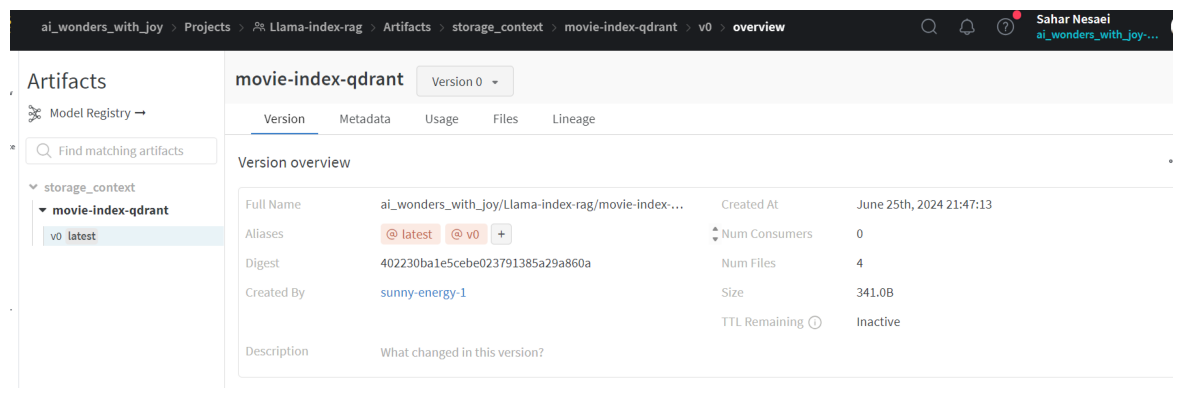

In [311]:
from PIL import Image
import matplotlib.pyplot as plt

# Load an image file
img_path = "MyartifactWandB.png"
img = Image.open(img_path)

plt.figure(figsize=(15, 10))

# Display the image using matplotlib
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


## Task 5: Simple RAG - QueryEngine

Now that we're created our `VectorStoreIndex`, powered by a QDrant VectorStore, we can wrap it in a simple `QueryEngine` using the `as_query_engine()` method - which will connect a few things together for us:

In [312]:

# Here is how we can have access to our index (vectorstoreindex)
simple_rag = index.as_query_engine()

Before we test this out - let's see what information we can find out about from our new `QueryEngine`!

In [313]:
for k, v in simple_rag.get_prompts().items():
  print(k, '::: ',v.get_template())
  print("\n~~~~~~~~~~~~~~~~~~\n")

response_synthesizer:text_qa_template :::  Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer: 

~~~~~~~~~~~~~~~~~~

response_synthesizer:refine_template :::  The original query is as follows: {query_str}
We have provided an existing answer: {existing_answer}
We have the opportunity to refine the existing answer (only if needed) with some more context below.
------------
{context_msg}
------------
Given the new context, refine the original answer to better answer the query. If the context isn't useful, return the original answer.
Refined Answer: 

~~~~~~~~~~~~~~~~~~



Let's see how it does!

In [314]:
response = simple_rag.query("Who is the evil Wizard in the story?")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


wandb: Logged trace tree to W&B.


In [315]:
response

Response(response='The evil wizard in the story is Saruman the White.', source_nodes=[NodeWithScore(node=TextNode(id_='81ff1c9a-99d6-4672-a85b-ef3b2e718438', embedding=None, metadata={'title': 'The Lord of the Rings: The Two Towers'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='173944', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='8a964a8be15461f84f36562053150f9d13018b43812e308b8610f23e1fe866b9'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='dc968590-5581-4ab0-816f-02bbc1a34408', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='70ea0f4cc420e685b68520104ea0ad85fc7f2db73d6b589f81c63e61378bc814'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='ca0c0d5b-c2f6-4942-a212-a1bcf6b65018', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='c0a34ccf6f5ab444b3a24a946bc83c74b800712a571fb78aedf3b3fa19a7bb2e')}, text='present during the entire battle in the book.\nOn the 

In [316]:
response.source_nodes[0].text

'present during the entire battle in the book.\nOn the way to Helm\'s Deep, the refugees from Edoras are attacked by Wargs, similar to a scene in The Fellowship of the Ring where the Fellowship battles a group of Wargs. Here, a new subplot is created where Aragorn falls over a cliff, and is assumed to be dead; Jackson stated that he added it to create tension. This scene also resonates with a new subplot regarding Arwen, where she decides to leave Middle-earth after losing hope in the long-term possibilities of her love. In the book, Arwen\'s role is primarily recorded in the Appendices, and she is never depicted as considering such an act.\nA larger change was originally planned: Arwen and Elrond would visit Galadriel, and Arwen would accompany an army of Elves to Helm\'s Deep to fight alongside Aragorn. During shooting, the script changed, both from writers coming up with better ideas to portray the romance between Aragorn and Arwen, as well as poor fan reaction. The new scene of Arw

In [317]:
response.metadata

{'81ff1c9a-99d6-4672-a85b-ef3b2e718438': {'title': 'The Lord of the Rings: The Two Towers'},
 'dc968590-5581-4ab0-816f-02bbc1a34408': {'title': 'The Lord of the Rings: The Two Towers'}}

In [318]:
response.source_nodes[0].metadata, response.source_nodes[1].metadata

({'title': 'The Lord of the Rings: The Two Towers'},
 {'title': 'The Lord of the Rings: The Two Towers'})

In [319]:
[x.metadata for x in response.source_nodes]

[{'title': 'The Lord of the Rings: The Two Towers'},
 {'title': 'The Lord of the Rings: The Two Towers'}]

In [320]:
[x.metadata['title'] for x in response.source_nodes]

['The Lord of the Rings: The Two Towers',
 'The Lord of the Rings: The Two Towers']

In [321]:
response.response

'The evil wizard in the story is Saruman the White.'

That makes sense!

Let's ask a question that's slightly more...ambiguous.

In [322]:
response = simple_rag.query("Who are the giant beings that roam across the world?")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


wandb: Logged trace tree to W&B.


In [323]:
response.response

'The giant beings that roam across the world are the sandworms.'

We can check the source nodes to see which movies we retrieved.

In [324]:
[x.metadata["title"] for x in response.source_nodes]

['Dune (2021 film)', 'The Lord of the Rings: The Fellowship of the Ring']

Okay, so in this case - we've gone with "Sandworms " from Dune.

But there's also the Ents from Lord of the Rings, and it looks like we got documents from Lord of the Rings as well.

Let's see if there's a way we can use the title metadata we added to filter the results we get!

In [326]:
collection_info = client.get_collection("movie_wikis")

# The schema information is contained in the 'config' field
schema = collection_info.config
schema.params

CollectionParams(vectors=VectorParams(size=1536, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None), shard_number=None, sharding_method=None, replication_factor=None, write_consistency_factor=None, read_fan_out_factor=None, on_disk_payload=None, sparse_vectors=None)

In [328]:
# we see it is so far a placeholder
num_vectors = collection_info.vectors_count
print(f"Number of vectors in the collection: {num_vectors}")


Number of vectors in the collection: None


In [329]:
index.vector_store.schema

<bound method BaseModel.schema of <class 'llama_index.vector_stores.qdrant.base.QdrantVectorStore'>>

In [330]:
num_nodes = len(index.index_struct.nodes_dict)

print(f"Number of nodes in the index: {num_nodes}")

Number of nodes in the index: 0


## Task 6: Auto Retriever Functional Tool

This tool will leverage OpenAI's functional endpoint to select the correct metadata filter and query the filtered index - only looking at nodes with the desired metadata.

A simplified diagram: ![image](https://i.imgur.com/AICDPav.png)

First, we need to create our `VectoreStoreInfo` object which will hold all the relevant metadata we need for each component (in this case title metadata).

Notice that you need to include it in a text list.

In [332]:
from llama_index.core.tools import FunctionTool
from llama_index.core.vector_stores.types import (
    VectorStoreInfo,
    MetadataInfo,
    ExactMatchFilter,
    MetadataFilters,
)
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine

from typing import List, Tuple, Any
from pydantic import BaseModel, Field

top_k = 3

vector_store_info = VectorStoreInfo(
    content_info="semantic information about movies",
    metadata_info=[MetadataInfo(
        name="title",
        type="str",
        description='title of the movie, one of ["Dune (2021 film)", "Dune: Part Two", "The Lord of the Rings: The Fellowship of the Ring", "The Lord of the Rings: The Two Towers"]'
        )]
)

Now we'll create our base PyDantic object that we can use to ensure compatability with our application layer. This verifies that the response from the OpenAI endpoint conforms to this schema.

In [333]:
class AutoRetrieveModel(BaseModel):
    query: str = Field(..., description="natural language query string")
    filter_key_list: List[str] = Field(
        ..., description="List of metadata filter field names"
    )
    filter_value_list: List[str] = Field(
        ...,
        description=(
            "List of metadata filter field values (corresponding to names specified in filter_key_list)"
        )
    )

# we have a class pydantic for data validation and settings management library using Python type annotations.
# You have Fields: 1: a main query string. 2: a list of str for metadata filter keys. 3: a list of str for metadata filter values
# Here quer is for user input. metadat list: ['title'], metadata list of values: [ the names that have been retrieved for context retrieved].
# Field(...): This is a Pydantic function used to provide extra information about a field. 
# ... means this Field is required. 
# descritption is a human readable desription for llm that of what this field is for.
#  

Now we can build our function that we will use to query the functional endpoint.

In [335]:
def auto_retrieve_fn(
    query: str, filter_key_list: List[str], filter_value_list: List[str]
):
    """Auto retrieval function.

    Performs auto-retrieval from a vector database, and then applies a set of filters.

    """
    query = query or "Query"

    exact_match_filters = [
        ExactMatchFilter(key=k, value=v)
        for k, v in zip(filter_key_list, filter_value_list)
    ]
    retriever = VectorIndexRetriever(
        index, filters=MetadataFilters(filters=exact_match_filters), top_k=top_k
    )
    query_engine = RetrieverQueryEngine.from_args(retriever)

    response = query_engine.query(query)
    return str(response)

Now we need to wrap our system in a tool in order to integrate it into the larger application.

Source Code Here:
- [`FunctionTool`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/tools/function_tool.py#L21)

In [337]:
description = f"""\
Use this tool to look up non-review based information about films.
The vector database schema is given below:
{vector_store_info.json()}
"""

auto_retrieve_tool = FunctionTool.from_defaults(
    fn=auto_retrieve_fn,
    name="semantic-film-info",
    description=description,
    fn_schema=AutoRetrieveModel
)

####❓ Question #3:

Is the text in the description of our `FunctionTool` important or not? Please explain your answer. Yes! This sounds like a system message that the pattern for our tool is instructed.

All that's left to do is attach the tool to an OpenAIAgent and let it rip!

Source Code Here:
- [`OpenAIAgent`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/agent/openai_agent.py#L361)

In [339]:
from llama_index.core.agent import FunctionCallingAgentWorker

agent_worker = FunctionCallingAgentWorker.from_tools(
    tools=[auto_retrieve_tool],
    verbose=True,
)

agent = agent_worker.as_agent()

In [340]:
response = agent.chat("Who starred in the 2021 film?")

Added user message to memory: Who starred in the 2021 film?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: semantic-film-info with args: {"query": "Who starred in the 2021 film?", "filter_key_list": ["title"], "filter_value_list": ["Dune (2021 film)"]}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Function Out

wandb: Logged trace tree to W&B.


=== LLM Response ===
The 2021 film "Dune" featured a star-studded cast, including:

- Timothée Chalamet as Paul
- Rebecca Ferguson as Lady Jessica
- Dave Bautista as Glossu Rabban
- Stellan Skarsgård as Baron Vladimir Harkonnen
- Charlotte Rampling as Gaius Helen Mohiam
- Oscar Isaac as Duke Leto
- Zendaya as Chani
- Javier Bardem as Stilgar
- Josh Brolin as Gurney Halleck
- Jason Momoa as Duncan Idaho
- David Dastmalchian as Piter de Vries
- Stephen McKinley Henderson
- Chang Chen as Dr. Yueh
- Benjamin Clementine as the Herald of the Change


In [341]:
response = agent.chat("Who are the giant beings that roam across the world in the movies?")

Added user message to memory: Who are the giant beings that roam across the world in the movies?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: semantic-film-info with args: {"query": "giant beings that roam across the world", "filter_key_list": ["title"], "filter_value_list": ["Dune (2021 film)"]}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat

wandb: Logged trace tree to W&B.


=== LLM Response ===
In the movies:

- **Dune (2021 film)**: The giant beings that roam across the world are the sandworms.
- **The Lord of the Rings: The Fellowship of the Ring**: There is no mention of giant beings that roam across the world in this context.
- **The Lord of the Rings: The Two Towers**: The giant beings that roam across the world are the Ents, led by Treebeard. They are ancient tree-like creatures who play a significant role in the story, particularly in their decision to go to war against Saruman after seeing the destruction he has caused to the forest.


In [342]:
print(str(response))

In the movies:

- **Dune (2021 film)**: The giant beings that roam across the world are the sandworms.
- **The Lord of the Rings: The Fellowship of the Ring**: There is no mention of giant beings that roam across the world in this context.
- **The Lord of the Rings: The Two Towers**: The giant beings that roam across the world are the Ents, led by Treebeard. They are ancient tree-like creatures who play a significant role in the story, particularly in their decision to go to war against Saruman after seeing the destruction he has caused to the forest.


# 🤝 Breakout Room #2

## Quantitative RAG Pipeline with NL2SQL Tooling

We'll walk through the steps of creating a natural language to SQL system in the following section.

> NOTICE: This does not have parsing on the inputs or intermediary calls to ensure that users are using safe SQL queries. Use this with caution in a production environment without adding specific guardrails from either side of the application.

The next few steps should be largely straightforward, we'll want to:

1. Read in our `.csv` files into `pd.DataFrame` objects
2. Create an in-memory `sqlite` powered `sqlalchemy` engine
3. Cast our `pd.DataFrame` objects to the SQL engine
4. Create an `SQLDatabase` object through LlamaIndex
5. Use that to create a `QueryEngineTool` that we can interact with through the `NLSQLTableQueryEngine`!

If you get stuck, please consult the documentation.

In [82]:
! wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune1.csv

--2024-06-27 14:32:29--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133391 (130K) [text/plain]
Saving to: ‘dune1.csv’

dune1.csv           100%[===================>] 130.26K  --.-KB/s    in 0.05s   

2024-06-27 14:32:29 (2.71 MB/s) - ‘dune1.csv’ saved [133391/133391]



In [263]:
! wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune2.csv

--2024-06-27 20:10:13--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111843 (109K) [text/plain]
Saving to: ‘dune2.csv.1’

dune2.csv.1         100%[===================>] 109.22K  --.-KB/s    in 0.04s   

2024-06-27 20:10:14 (3.03 MB/s) - ‘dune2.csv.1’ saved [111843/111843]



In [264]:
! wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/lotr_fotr.csv

--2024-06-27 20:10:17--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/lotr_fotr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172855 (169K) [text/plain]
Saving to: ‘lotr_fotr.csv.1’

lotr_fotr.csv.1     100%[===================>] 168.80K  --.-KB/s    in 0.05s   

2024-06-27 20:10:17 (3.30 MB/s) - ‘lotr_fotr.csv.1’ saved [172855/172855]



In [265]:
! wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/lotr_tt.csv

--2024-06-27 20:10:21--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/lotr_tt.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114598 (112K) [text/plain]
Saving to: ‘lotr_tt.csv.1’

lotr_tt.csv.1       100%[===================>] 111.91K  --.-KB/s    in 0.04s   

2024-06-27 20:10:21 (2.48 MB/s) - ‘lotr_tt.csv.1’ saved [114598/114598]



#### Read `.csv` Into Pandas

In [343]:
import pandas as pd

dune1 = pd.read_csv("./dune1.csv")
dune2 = pd.read_csv("./dune2.csv")
lotr_fotr = pd.read_csv("./lotr_fotr.csv")
lotr_tt = pd.read_csv("./lotr_tt.csv")

#### Create SQLAlchemy engine with SQLite

In [345]:
from sqlalchemy import create_engine

engine = create_engine("sqlite+pysqlite:///:memory:")

#### Convert `pd.DataFrame` to SQL tables

In [346]:
dune1.to_sql(
  "Dune (2021 film)",
  engine
)

274

# Let me for fun see th equey from this table :)

In [347]:
from sqlalchemy import text

with engine.connect() as connection:
    # Get the first few rows of the table
    query = text("SELECT * FROM \"Dune (2021 film)\" LIMIT 5")
    result = connection.execute(query)
    rows = result.fetchall()
    # Print the column names
    print("Columns:", result.keys())

    # Print the first few rows
    print("\nFirst 5 rows:")
    for row in rows:
        print(row)

    # Get the total number of rows
    count_query = text("SELECT COUNT(*) FROM \"Dune (2021 film)\"")
    count_result = connection.execute(count_query)
    total_rows = count_result.scalar()
    print(f"\nTotal number of rows: {total_rows}")

# If you want to see the data as a DataFrame
df = pd.read_sql_query("SELECT * FROM \"Dune (2021 film)\"", engine)
print("\nDataFrame head:")
print(df.head())

# To see the data types of the columns
print("\nColumn data types:")
print(df.dtypes)

Columns: RMKeyView(['index', 'Unnamed: 0', 'Review_Date', 'Author', 'Rating', 'Review_Title', 'Review', 'Review_Url'])

First 5 rows:
(0, 0, '13 September 2021', 'FabledGentleman', 9.0, ' DUNE - A Great Modern Sci-Fi\n', "Denis Villeneuve has accomplished what was considered impossible for decades, to write and direct a faithful adaptation to the fantastic 1965 sci-fi novel by Frank Herbert. And I'm here to tell you, he has done it, he has actually done it.", '/review/rw7338282/?ref_=tt_urv')
(1, 1, '23 October 2021', 'Sleepin_Dragon', 10.0, ' My movie of 2021, so far.\n', "It's been amazing being back in cinemas after last year, I have seen some good films, and some shockers, this though, is the first great film of the year for me.", '/review/rw7475243/?ref_=tt_urv')
(2, 2, '22 October 2021', 'classicsoncall', 9.0, ' "He shall know your ways as though born to them."\n', "It's been some time since I've read the Frank Herbert novel, and I had already forgotten much of the story. However

In [350]:
# note we are giving metadata to them by their titles!
dune2.to_sql(
  "Dune: Part Two",
  engine
)

In [351]:
lotr_fotr.to_sql(
  "The Lord of the Rings: The Fellowship of the Ring",
  engine
)

250

In [352]:
lotr_tt.to_sql(
  "The Lord of the Rings: The Two Towers",
  engine
)

149

#### Construct a `SQLDatabase` index

4. Create an `SQLDatabase` object through LlamaIndex
5. Use that to create a `QueryEngineTool` that we can interact with through the `NLSQLTableQueryEngine`!

Source Code Here:
- [`SQLDatabase`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/langchain_helpers/sql_wrapper.py#L9)

In [353]:
from llama_index.core import SQLDatabase

sql_database = SQLDatabase(
    engine=engine,
    include_tables=movie_list
)

#### Create the NLSQLTableQueryEngine interface for all added SQL tables

Source Code Here:
- [`NLSQLTableQueryEngine`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/indices/struct_store/sql_query.py#L75C1-L75C1)

In [274]:
from llama_index.core.indices.struct_store.sql_query import NLSQLTableQueryEngine

sql_query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database,
    tables=movie_list,
)

#### Wrap It All Up in a `QueryEngineTool`

You'll want to ensure you have a descriptive...description!

This is what will help the LLM decide which table to use when querying!

Sorce Code Here:

- [`QueryEngineTool`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/tools/query_engine.py#L13)

####🏗️ Activity #1:

Please write a Natural Language Description for the tables that we are using today.

Here is an example:

```
This tool should be used to answer any and all review related inquiries by translating a natural language query into a SQL query with access to tables:
'Dune (2021 film)' - containing info. about the first movie in the Dune series,
'Dune: Part Two'- containing info. about about the second movie in the Dune series,
'The Lord of the Rings: The Fellowship of the Ring' - containing info. about the first movie in the Lord of the Ring series,
'The Lord of the Rings: The Two Towers' - containing info. the second movie in the Lord of the Ring series,
```

In [354]:
DESCRIPTION = """\
Use this tool to look to answer any and all review related inquiries by translating natural language query into SQL query
and execute the query. If you don't know the answer based on the tables, say you don't know.

Tables:
{sql_databesae}

"""


In [355]:
from llama_index.core.tools.query_engine import QueryEngineTool

sql_tool = QueryEngineTool.from_defaults(
    query_engine=sql_query_engine,
    name="sql-query",
    description=DESCRIPTION,
)

FunctionCallingAgentWorker leverages the pydantic object function calling autoretriever tool and Agentworkers -> Meta data filtering

In [356]:
agent_worker = FunctionCallingAgentWorker.from_tools(
    tools=[sql_tool],
    verbose=True
)
#OpenAiAgent.from_tools(.)
agent = agent_worker.as_agent()

In [357]:
response = agent.chat("What is the average rating of the 2nd Lord of the Rings movie?")

Added user message to memory: What is the average rating of the 2nd Lord of the Rings movie?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: sql-query with args: {"input": "SELECT AVG(rating) FROM reviews WHERE movie_title = 'The Lord of the Rings: The Two Towers'"}
INFO:llama_index.core.indices.struct_store.sql_retriever:> Table desc str: Table 'Dune (2021 film)' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .

Table 'Dune: Part Two' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .

Table 'The

wandb: Logged trace tree to W&B.


=== LLM Response ===
The average rating for "The Lord of the Rings: The Two Towers" is approximately 9.18.


In [358]:
print(str(response))

The average rating for "The Lord of the Rings: The Two Towers" is approximately 9.18.


In [359]:
response = agent.chat("What movie series has better reviews, Lord of the Rings or Dune?")

Added user message to memory: What movie series has better reviews, Lord of the Rings or Dune?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: sql-query with args: {"input": "SELECT AVG(rating) FROM reviews WHERE movie_title LIKE 'The Lord of the Rings%'"}
INFO:llama_index.core.indices.struct_store.sql_retriever:> Table desc str: Table 'Dune (2021 film)' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .

Table 'Dune: Part Two' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .

Table 'The Lord of t

wandb: Logged trace tree to W&B.


=== LLM Response ===
The average rating for the "Dune" series is approximately 8.34, while the "Lord of the Rings" series has an average rating of approximately 9.87.

Based on these ratings, the "Lord of the Rings" series has better reviews compared to the "Dune" series.


In [360]:
print(str(response))

The average rating for the "Dune" series is approximately 8.34, while the "Lord of the Rings" series has an average rating of approximately 9.87.

Based on these ratings, the "Lord of the Rings" series has better reviews compared to the "Dune" series.


### Task 2: Combined RAG Pipeline

Now, we can simply add our tools into the `OpenAIAgent`, and off we go!

In [361]:
combined_tool_agent_worker = FunctionCallingAgentWorker.from_tools(
    tools=[auto_retrieve_tool, sql_tool],
    verbose=True
)
combined_tool_agent = combined_tool_agent_worker.as_agent()

In [362]:
response = combined_tool_agent.chat("Which movie is about a ring, and what is the average rating of the movie?")

Added user message to memory: Which movie is about a ring, and what is the average rating of the movie?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: semantic-film-info with args: {"query": "movie about a ring", "filter_key_list": ["title"], "filter_value_list": ["The Lord of the Rings: The Fellowship of the Ring", "The Lord of the Rings: The Two Towers"]}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1

wandb: Logged trace tree to W&B.


=== LLM Response ===
The movie about a ring is "The Lord of the Rings: The Fellowship of the Ring." It follows the story of the Dark Lord Sauron, who seeks the One Ring to return to power. The Ring has found its way to a young hobbit named Frodo Baggins. The story follows Frodo and eight companions, who form the Fellowship of the Ring, as they embark on a perilous journey to Mount Doom in Mordor, the only place where the Ring can be destroyed.

Regarding the average rating of the movie, there was an error in the SQL query execution. Here is the corrected SQL query to calculate the average rating for the specified movies:

```sql
SELECT AVG(rating) as average_rating
FROM reviews
WHERE movie_title IN ('The Lord of the Rings: The Fellowship of the Ring', 'The Lord of the Rings: The Two Towers');
```

This query will correctly compute the average rating from the `reviews` table for the movies "The Lord of the Rings: The Fellowship of the Ring" and "The Lord of the Rings: The Two Towers".


In [363]:
print(str(response))

The movie about a ring is "The Lord of the Rings: The Fellowship of the Ring." It follows the story of the Dark Lord Sauron, who seeks the One Ring to return to power. The Ring has found its way to a young hobbit named Frodo Baggins. The story follows Frodo and eight companions, who form the Fellowship of the Ring, as they embark on a perilous journey to Mount Doom in Mordor, the only place where the Ring can be destroyed.

Regarding the average rating of the movie, there was an error in the SQL query execution. Here is the corrected SQL query to calculate the average rating for the specified movies:

```sql
SELECT AVG(rating) as average_rating
FROM reviews
WHERE movie_title IN ('The Lord of the Rings: The Fellowship of the Ring', 'The Lord of the Rings: The Two Towers');
```

This query will correctly compute the average rating from the `reviews` table for the movies "The Lord of the Rings: The Fellowship of the Ring" and "The Lord of the Rings: The Two Towers".


## Interestingly, it is not able to solve the question when now a list of Agents has passed. Then, I will go for OpenAIAgent:

In [364]:
from llama_index.agent.openai import OpenAIAgent
combined_tool_agent_openai = OpenAIAgent.from_tools(
    tools=[auto_retrieve_tool, sql_tool],
    verbose=True
)
#OpenAiAgent.from_tools(tools=[auto_retriever_tool, sql_tool], verbose=True)
response = combined_tool_agent_openai.chat("Which movie is about a ring, and what is the average rating of the movie?")

Added user message to memory: Which movie is about a ring, and what is the average rating of the movie?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: semantic-film-info with args: {"query": "movie about a ring", "filter_key_list": ["title"], "filter_value_list": ["The Lord of the Rings: The Fellowship of the Ring", "The Lord of the Rings: The Two Towers"]}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1

wandb: Logged trace tree to W&B.


In [365]:
print(str(response))

The movie about a ring is "The Lord of the Rings: The Fellowship of the Ring." The story follows Frodo Baggins and his companions as they embark on a journey to destroy the One Ring, which the Dark Lord Sauron seeks to regain his power.

Regarding the average rating of the movie, there seems to be an issue with retrieving the data. However, you can use the following SQL query to find the average rating for both "The Lord of the Rings: The Fellowship of the Ring" and "The Lord of the Rings: The Two Towers":

```sql
SELECT AVG(rating) as average_rating 
FROM reviews 
WHERE movie_title IN ('The Lord of the Rings: The Fellowship of the Ring', 'The Lord of the Rings: The Two Towers');
```

If you need the average rating for each movie separately, you can use this query:

```sql
SELECT movie_title, AVG(rating) as average_rating 
FROM reviews 
WHERE movie_title IN ('The Lord of the Rings: The Fellowship of the Ring', 'The Lord of the Rings: The Two Towers')
GROUP BY movie_title;
```

These qu

In [366]:
print(str(response))

The movie about a ring is "The Lord of the Rings: The Fellowship of the Ring." The story follows Frodo Baggins and his companions as they embark on a journey to destroy the One Ring, which the Dark Lord Sauron seeks to regain his power.

Regarding the average rating of the movie, there seems to be an issue with retrieving the data. However, you can use the following SQL query to find the average rating for both "The Lord of the Rings: The Fellowship of the Ring" and "The Lord of the Rings: The Two Towers":

```sql
SELECT AVG(rating) as average_rating 
FROM reviews 
WHERE movie_title IN ('The Lord of the Rings: The Fellowship of the Ring', 'The Lord of the Rings: The Two Towers');
```

If you need the average rating for each movie separately, you can use this query:

```sql
SELECT movie_title, AVG(rating) as average_rating 
FROM reviews 
WHERE movie_title IN ('The Lord of the Rings: The Fellowship of the Ring', 'The Lord of the Rings: The Two Towers')
GROUP BY movie_title;
```

These qu

In [367]:
response = combined_tool_agent.chat("What worlds do the LoTR, and Dune movies take place in?")

Added user message to memory: What worlds do the LoTR, and Dune movies take place in?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: semantic-film-info with args: {"query": "world where The Lord of the Rings takes place", "filter_key_list": ["title"], "filter_value_list": ["The Lord of the Rings: The Fellowship of the Ring", "The Lord of the Rings: The Two Towers"]}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completion

wandb: Logged trace tree to W&B.


=== LLM Response ===
The worlds where the movies take place are as follows:

- **The Lord of the Rings**: The story takes place in a world called **Middle-earth**.
- **Dune**: The story is set in the distant future and primarily revolves around the desert planet **Arrakis**. Other significant planets include **Caladan**, the home planet of House Atreides, and **Giedi Prime**, the home of House Harkonnen.


In [368]:
print(str(response))

The worlds where the movies take place are as follows:

- **The Lord of the Rings**: The story takes place in a world called **Middle-earth**.
- **Dune**: The story is set in the distant future and primarily revolves around the desert planet **Arrakis**. Other significant planets include **Caladan**, the home planet of House Atreides, and **Giedi Prime**, the home of House Harkonnen.


In [369]:
response = combined_tool_agent.chat("Which of the following movie series is considered the 'best': Dune, or Lord of the Rings? Base your answer on both reviews, and non-review information.")

Added user message to memory: Which of the following movie series is considered the 'best': Dune, or Lord of the Rings? Base your answer on both reviews, and non-review information.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: semantic-film-info with args: {"query": "which is considered the best movie series: Dune or Lord of the Rings", "filter_key_list": ["title"], "filter_value_list": ["Dune (2021 film)", "Dune: Part Two", "The Lord of the Rings: The Fellowship of the Ring", "The Lord of the Rings: The Two Towers"]}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 20

wandb: Logged trace tree to W&B.


=== LLM Response ===
Based on the information gathered:

### Non-Review Information:
- **Dune**: The "Dune" series has received numerous accolades and has been praised for its adaptation.
- **The Lord of the Rings**: The "Lord of the Rings" film series is highly celebrated for its faithful adaptation and success.

### Review Information:
There was an error in executing the SQL query to fetch the average ratings. However, the corrected SQL query to determine the average ratings for the movies is:

```sql
SELECT movie_title, AVG(rating) as average_rating 
FROM reviews 
WHERE movie_title IN ('Dune (2021 film)', 'Dune: Part Two', 'The Lord of the Rings: The Fellowship of the Ring', 'The Lord of the Rings: The Two Towers') 
GROUP BY movie_title;
```

This query will calculate the average rating for each of the specified movies from the "reviews" table.

### Conclusion:
Both series have their own merits and have been critically acclaimed in different ways. The preference for one over the oth

In [370]:
print(str(response))

Based on the information gathered:

### Non-Review Information:
- **Dune**: The "Dune" series has received numerous accolades and has been praised for its adaptation.
- **The Lord of the Rings**: The "Lord of the Rings" film series is highly celebrated for its faithful adaptation and success.

### Review Information:
There was an error in executing the SQL query to fetch the average ratings. However, the corrected SQL query to determine the average ratings for the movies is:

```sql
SELECT movie_title, AVG(rating) as average_rating 
FROM reviews 
WHERE movie_title IN ('Dune (2021 film)', 'Dune: Part Two', 'The Lord of the Rings: The Fellowship of the Ring', 'The Lord of the Rings: The Two Towers') 
GROUP BY movie_title;
```

This query will calculate the average rating for each of the specified movies from the "reviews" table.

### Conclusion:
Both series have their own merits and have been critically acclaimed in different ways. The preference for one over the other may vary based on 

####❓ Question #4:

How can you verify which tool was used for which query?

In [62]:
wandb_callback.finish()